# k-means Clustering

In [1]:
# Required:
!pip install opencv-python
!pip install plyfile 

# Libraries
import os
import cv2
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Current activated conda environment (aktuelles Envirement, dass man implementiert hat)
env = !conda info | grep 'active env'
print('Current activated conda environment:', str(env[0]).strip())

#Current working directory
print('\nCurrent working directory:', os.getcwd())

Current activated conda environment: Der Befehl "grep" ist entweder falsch geschrieben oder

Current working directory: C:\Workspacezhaw\data_analytics\Woche 10


## 4.) Finding clusters in the apartment data
<a id='section_4'></a>

### Import the apartment data

In [2]:
# Dasselbe kann man auch auf die Apartement Data anwenden
# Define columns for import
columns = [ 'web-scraper-order',
            'address_raw',
            'rooms',
            'area',
            'luxurious',
            'price',
            'price_per_m2',
            'lat',
            'lon',
            'bfs_number',
            'bfs_name',
            'pop',
            'pop_dens',
            'frg_pct',
            'emp',
            'tax_income',
            'dist_supermarket']

# Read and select variables
df_orig = pd.read_csv("apartments_data_enriched.csv", sep=";", encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & 
            (df['price'] <= 5000)]

print(df.shape)
df.head(5)

(804, 17)


,id,address_raw,rooms,area,luxurious,price,price_per_m2,lat,lon,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,tax_income,dist_supermarket
0,1662023695-433,"Sunnenbergstrasse 15, 8633 Wolfhausen, ZH",3.5,122,1,3180,26.07,47.255714,8.804976,112,Bubikon,7344,632.558140,11.410675,3617.0,79385.90434,317.117916
1,1662023720-634,"Blumenbergstrasse 7, 8633 Wolfhausen, ZH",4.0,87,0,1690,19.43,47.254879,8.793746,112,Bubikon,7344,632.558140,11.410675,3617.0,79385.90434,612.612674
2,1662023745-834,"8608 Bubikon, ZH",3.5,92,0,2350,25.54,47.277386,8.800306,112,Bubikon,7344,632.558140,11.410675,3617.0,79385.90434,2269.090923
3,1662023701-503,"8608 Bubikon, ZH",3.5,130,0,2500,19.23,47.277386,8.800306,112,Bubikon,7344,632.558140,11.410675,3617.0,79385.90434,2269.090923
4,1662023745-820,"Lavaterstr. 63, 8002 Zürich, ZH",2.5,78,0,3760,48.21,47.361378,8.533339,261,Zürich,420217,4778.994655,32.458468,491193.0,82932.73770,349.937421


### Subset of the apartment data frame for k-means clustering

In [3]:
# Define a subset of the data frame for k-means clustering (auf Basis von Räumen, Fläche und m2 als Parameter)
X3 = df[['rooms',
         'area',
         'lat', 'lon', 'pop_dens', 'tax_income','bfs_number',
            'pop',
            'frg_pct',
            'emp',
            'tax_income',
            'dist_supermarket',
        'price_per_m2']]
#das ist alles in x3:
X3

,rooms,area,lat,lon,pop_dens,tax_income,bfs_number,pop,frg_pct,emp,tax_income,dist_supermarket,price_per_m2
0,3.5,122,47.255714,8.804976,632.558140,79385.90434,112,7344,11.410675,3617.0,79385.90434,317.117916,26.07
1,4.0,87,47.254879,8.793746,632.558140,79385.90434,112,7344,11.410675,3617.0,79385.90434,612.612674,19.43
2,3.5,92,47.277386,8.800306,632.558140,79385.90434,112,7344,11.410675,3617.0,79385.90434,2269.090923,25.54
3,3.5,130,47.277386,8.800306,632.558140,79385.90434,112,7344,11.410675,3617.0,79385.90434,2269.090923,19.23
4,2.5,78,47.361378,8.533339,4778.994655,82932.73770,261,420217,32.458468,491193.0,82932.73770,349.937421,48.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,4.5,136,47.223232,8.458288,367.542504,79514.42105,7,2378,18.292683,566.0,79514.42105,223.876557,19.19
866,4.5,85,47.219131,8.466013,367.542504,79514.42105,7,2378,18.292683,566.0,79514.42105,593.657413,20.12
867,3.5,94,47.322720,8.541389,3458.527132,166467.20300,135,8923,32.858904,4127.0,166467.20300,657.239570,27.66
868,4.5,115,47.562801,8.732790,130.440252,77400.24213,214,1037,7.810993,264.0,77400.24213,2874.075255,22.43


### Elbow method showing the optimal k

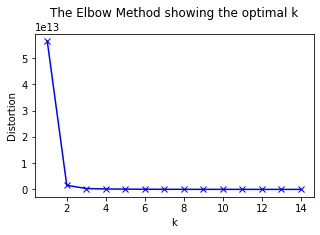

In [4]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,15)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X3)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()
#Elbow-method ab 5-7 sinnvoll

### Perform k-means clustering on the apartment data

In [5]:
# Number of cluters
k = 2

# Perform k-means clustering
kmeans_apmts = KMeans(n_clusters=k, random_state=42).fit(X3)

# Add the clusters to data frame
X3['cluster'] = kmeans_apmts.predict(X3)

# Show number of apartments per cluster
X3['cluster'].value_counts().sort_values(ascending=False)


kmeans_apmts.inertia_
#Wert basisert auf allen Daten 

1577432462553.0444

In [6]:
print(kmeans_apmts.labels_, '\n')
print(kmeans_apmts.inertia_, '\n')
print(kmeans_apmts.cluster_centers_, '\n')
print(kmeans_apmts.feature_names_in_)

[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

### Erklärung
The k-means problem is solved using either Lloyd’s or Elkan’s algorithm.
The average complexity is given by O(k n T), where n is the number of samples and T is the number of iteration.
The worst case complexity is given by O(n^(k+2/p)) with n = n_samples, p = n_features. (D. Arthur and S. Vassilvitskii, ‘How slow is the k-means method?’ SoCG2006)
In practice, the k-means algorithm is very fast (one of the fastest clustering algorithms available), but it falls in local minima. That’s why it can be useful to restart it several times.
If the algorithm stops before fully converging (because of tol or max_iter), labels_ and cluster_centers_ will not be consistent, i.e. the cluster_centers_ will not be the means of the points in each cluster. Also, the estimator will reassign labels_ after the last iteration to make labels_ consistent with predict on the training set

##### print(kmeans_apmts.labels_, '\n')
Labels of each point

##### print(kmeans_apmts.inertia_, '\n')
Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.

##### print(kmeans_apmts.cluster_centers_, '\n')
Coordinates of cluster centers. If the algorithm stops before fully converging (see tol and max_iter), these will not be consistent with labels_.

##### print(kmeans_apmts.feature_names_in_)
Names of features seen during fit. Defined only when X has feature names that are all strings.

### Plot the apartment clusters

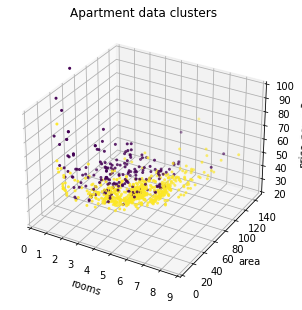

In [7]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['rooms'], df['area'], df['price_per_m2'], c=kmeans_apmts.labels_, s=4)

# Set title and axes labels
ax.set_title('Apartment data clusters', fontsize=12)
ax.set_xlabel('rooms', fontsize=10)
ax.set_ylabel('area', fontsize=10)
ax.set_zlabel('price_per_m2', fontsize=10)

# Set axes range
ax.set_xlim([0,9])
ax.set_ylim([0,150])
ax.set_zlim([20,100])

plt.show()
#weil es nur drei Variablen sind, kann man es in einem 3d-Modell darstellen : rooms, area and price_per_m2
#Farben sind die Cluster (aus dem k=5 (fünf Cluster))
# Man erkennt, eine klare Abgrenzung der Daten 80-100m2 , gelb: 2-4 Zimmer etc.
# Cluster funktionieren bei allen Daten , Cluster könnte man im Nachhinein genauer untersuchen
# hellgrün => ganz grosse wohnungen (in Ecke bei price_per_m2)
# nur nummerische werte aus Daten nehmen (Projekt) und dann anwenden!

### Calculate the Silhouette Score

In [8]:
print(f'Silhouette Score: {silhouette_score(X3, kmeans_apmts.labels_):.4f}')

Silhouette Score: 0.9313


Recht nah gewählt (vlt wäre k=1 besser wie k=2 gewesen)

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [9]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2023-01-21 17:46:32
Python Version: 3.9.7
-----------------------------------
